### Import Library

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [80]:
X = pd.read_csv('dataset/fitur.csv').values
X

array([[0.5137741 , 0.74558996, 0.78156792, 0.20550526],
       [0.59937033, 0.65895727, 0.78575703, 0.28307523],
       [0.48248721, 0.67346139, 0.80670257, 0.25265383],
       ...,
       [0.48465171, 0.03606429, 0.09694794, 0.0706769 ],
       [0.454939  , 0.24382595, 0.3967684 , 0.07145811],
       [0.67827627, 0.81575853, 0.7432675 , 0.49119985]])

In [81]:
y = pd.read_csv('dataset/target.csv').values
y

array([[0.70550539],
       [0.73579959],
       [0.71103991],
       ...,
       [0.20128168],
       [0.40576755],
       [0.8311972 ]])

### Split Data

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

##### Inisialisasi bobot dan bias

In [83]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append(np.random.rand(4, hidden_neuron[i]).tolist())
        else:
            bobot.append(np.random.rand(hidden_neuron[i-1], hidden_neuron[i]).tolist())
        bias.append(np.random.rand(hidden_neuron[i]).tolist())
    bobot_output = np.random.rand(hidden_neuron[-1]).tolist()
    bias_output = np.random.rand()
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [84]:
def relu(x):
    if x > 0:
        return x
    else:
        return 0

def turunan_relu(x):
    if x > 0:
        return 1
    else:
        return 0 

##### Fungsi Training

In [85]:
def ann(epochs, hidden_layer, hidden_neuron, lr, X_train, y_train):
    bobot, bias, bobot_output, bias_output = inisialisasi(hidden_layer, hidden_neuron)
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(relu(sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = relu(sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunan_relu(prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0


                    
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i)][k] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 



        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output

##### Training + Tuning

In [86]:
hidden_layer = 2
hidden_neuron = [2, 2]
lr = 0.005
epoch = 100

best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output = ann(epoch, hidden_layer, hidden_neuron, lr, X_train, y_train)

Epoch 1, MSE: 2.2218537061447172
Epoch 2, MSE: 0.065009983890188
Epoch 3, MSE: 0.06422144373677649
Epoch 4, MSE: 0.063445568822016
Epoch 5, MSE: 0.06268214650465566
Epoch 6, MSE: 0.06193096780374625
Epoch 7, MSE: 0.06119182733479011
Epoch 8, MSE: 0.060464523247011806
Epoch 9, MSE: 0.05974885716172879
Epoch 10, MSE: 0.05904463411180738
Epoch 11, MSE: 0.058351662482182126
Epoch 12, MSE: 0.05766975395141462
Epoch 13, MSE: 0.05699872343428552
Epoch 14, MSE: 0.05633838902538996
Epoch 15, MSE: 0.0556885719437243
Epoch 16, MSE: 0.055049096478245976
Epoch 17, MSE: 0.05441978993438812
Epoch 18, MSE: 0.0538004825815171
Epoch 19, MSE: 0.05319100760130399
Epoch 20, MSE: 0.052591201037011384
Epoch 21, MSE: 0.05200090174366395
Epoch 22, MSE: 0.05141995133909623
Epoch 23, MSE: 0.050848194155858666
Epoch 24, MSE: 0.05028547719396693
Epoch 25, MSE: 0.04973165007448175
Epoch 26, MSE: 0.049186564993901206
Epoch 27, MSE: 0.04865007667935496
Epoch 28, MSE: 0.04812204234458287
Epoch 29, MSE: 0.0476023216466

In [87]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [1, 2, 3]
    neuron_values = [2, 3]
    lr_values = [0.005, 0.01]
    epoch_values = [100, 200]

    hidden_layer_list = []
    hidden_neuron_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []

    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            for lr in lr_values:
                for epoch in epoch_values:
                    print(f"HIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, LR={lr}, EPOCH={epoch}")
                    mse, bobot, bias, bobot_output, bias_output = ann(epoch, hidden_layer, list(hidden_neuron_combination), lr, X_train, y_train)
                    hidden_layer_list.append(hidden_layer)
                    hidden_neuron_list.append(tuple(hidden_neuron_combination))
                    lr_list.append(lr)
                    epoch_list.append(epoch)
                    mse_list.append(mse)
                    bobot_list.append(bobot)
                    bias_list.append(bias)
                    bobot_output_list.append(bobot_output)
                    bias_output_list.append(bias_output)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [88]:
tuning = tuning_hyperparameters(X_train, y_train)

HIDDEN LAYER=1, HIDDEN NEURON=(2,), LR=0.005, EPOCH=100
Epoch 1, MSE: 0.03885473512876466
Epoch 2, MSE: 0.3359525679049081
Epoch 3, MSE: 0.1509514273258275
Epoch 4, MSE: 0.05100902655439871
Epoch 5, MSE: 0.01128677367482621
Epoch 6, MSE: 0.0016207174838802096
Epoch 7, MSE: 0.0002795919312258105
Epoch 8, MSE: 0.00023000771694865483
Epoch 9, MSE: 0.00026953729474205236
Epoch 10, MSE: 0.0002892972402389966
Epoch 11, MSE: 0.00029657785564084243
Epoch 12, MSE: 0.00029906533051810453
Epoch 13, MSE: 0.00029989585320373385
Epoch 14, MSE: 0.000300171101463691
Epoch 15, MSE: 0.0003002621018189335
Epoch 16, MSE: 0.00030029216357068593
Epoch 17, MSE: 0.0003003020917792719
Epoch 18, MSE: 0.0003003053703886801
Epoch 19, MSE: 0.0003003064530583104
Epoch 20, MSE: 0.0003003068105765055
Epoch 21, MSE: 0.0003003069286354865
Epoch 22, MSE: 0.0003003069676206229
Epoch 23, MSE: 0.00030030698049421806
Epoch 24, MSE: 0.00030030698474532355
Epoch 25, MSE: 0.00030030698614911405
Epoch 26, MSE: 0.000300306986612

##### Visualisasi hasil tuning

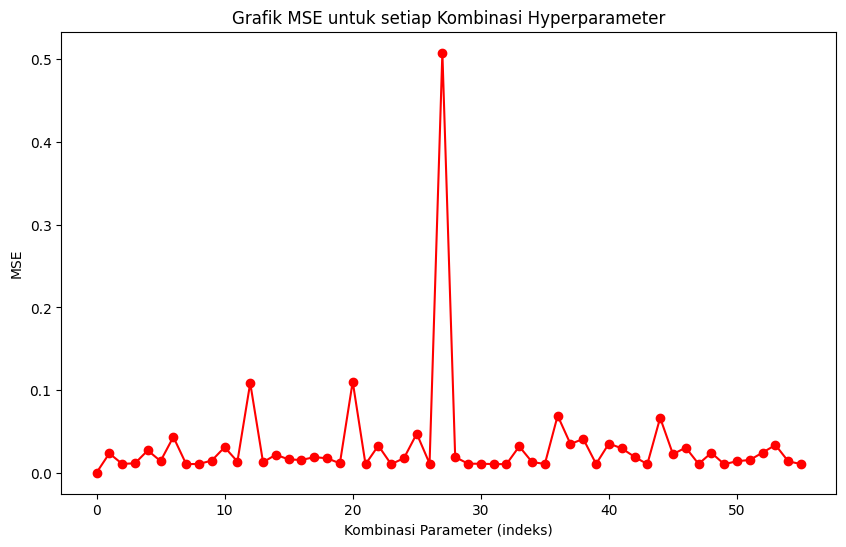

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [90]:
tuning

,hidden_layer,hidden_neuron,lr,epoch,mse,bobot,bias,bobot_output,bias_output
0,1,"(2,)",0.005,100,0.000230,"[[[2.1149921444744595, -1.3063137786469436], [...","[[0.9931521572367542, -1.1853080845469448]]","[0.11438491867820964, 0.41475889714146613]",0.016972
1,1,"(2,)",0.005,200,0.023613,"[[[-19.704604650811476, -12.357825726905382], ...","[[0.31154226367907134, -19.10636280851305]]","[0.7463317699354726, 0.46877408535546256]",0.818773
2,1,"(2,)",0.010,100,0.010985,"[[[-30.965648989907905, -40.47309670094468], [...","[[0.44604438114469214, -62.97937756637829]]","[0.4232035471372407, 0.5532003919473307]",0.687002
3,1,"(2,)",0.010,200,0.011562,"[[[-1.033080901693291, -2.898991806218497], [-...","[[0.9763839079565987, -4.922092868864016]]","[0.14546683261206295, 0.2955617731570944]",0.680227
4,1,"(3,)",0.005,100,0.027213,"[[[-3.136900629749726, -6.208642605332485, -15...","[[0.008685912676787533, 0.15082779633780707, -...","[0.14766790196311871, 0.26766136999713924, 0.6...",0.577176
5,1,"(3,)",0.005,200,0.014296,"[[[-1.2772031483514106, -42.10342458630943, -4...","[[0.9137450763378411, 0.7608155076291347, -63....","[0.013589709502514279, 0.8384017796349049, 0.8...",0.646952
6,1,"(3,)",0.010,100,0.043522,"[[[-9.335057504960817, -7.760242644626927, -30...","[[0.16249695925327468, 0.6356921940392866, -48...","[0.21757588924941265, 0.17162468540322687, 0.7...",0.526130
7,1,"(3,)",0.010,200,0.010616,"[[[-29.495694963687814, -35.25660736864211, -3...","[[0.07755009282274428, 0.020905551814340617, -...","[0.514026321954418, 0.6167721604212787, 0.0474...",0.700088
8,2,"(2, 2)",0.005,100,0.010849,"[[[-30.989174607345394, -33.86266582411707], [...","[[0.042123200104739134, -51.92831844341559], [...","[0.8308264757685188, 0.976370438325953]",0.074819
9,2,"(2, 2)",0.005,200,0.014934,"[[[-14.146084183938457, -16.409810537639917], ...","[[0.47545152332466856, -25.186289603148484], [...","[0.3738322708405279, 0.8682142084686986]",0.542531


In [91]:
best_index = tuning['mse'].idxmin()
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]

print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)

Best MSE: 0.00023000771694865483
Best Bobot: [[[np.float64(2.1149921444744595), np.float64(-1.3063137786469436)], [np.float64(2.262196652062094), np.float64(-1.1792654525057715)], [np.float64(2.628960289544617), np.float64(-0.7683913963725967)], [np.float64(1.9125484026187927), np.float64(0.31421234232279394)]]]
Best Bias: [[0.9931521572367542, np.float64(-1.1853080845469448)]]
Best Bobot Output: [np.float64(0.11438491867820964), np.float64(0.41475889714146613)]
Best Bias Output: 0.016972478073797037


### Prediksi X_test

##### Data testing

In [92]:
X_test

array([[0.72924046, 0.78047824, 0.77438659, 0.37263913],
       [0.66017316, 0.5876127 , 0.6888091 , 0.28629199],
       [0.50314837, 0.29086633, 0.48473968, 0.06663297],
       ...,
       [0.69047619, 0.79655037, 0.82405745, 0.37314462],
       [0.61275089, 0.36926695, 0.6181927 , 0.10096043],
       [0.5922865 , 0.69933359, 0.66367445, 0.33803594]])

##### Fungsi prediksi X_test

In [93]:
def predict(X_test, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_test)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_test[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Pemanggilan fungsi prediksi

In [94]:
prediksi = predict(X_test, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)

##### Visualisasi hasil prediksi dan aktual

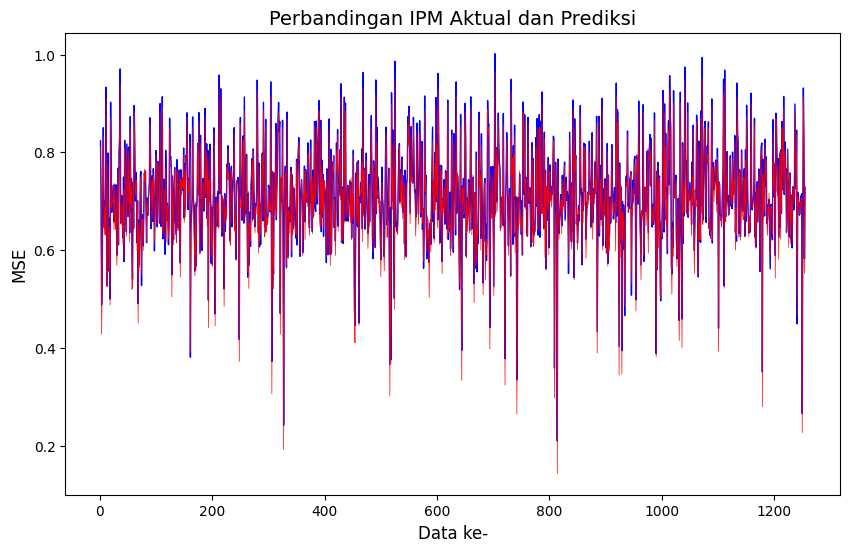

In [95]:
datake = list(range(1, len(y_test)+1))
plt.figure(figsize=(10, 6))
plt.plot(datake, prediksi, label="ipm prediksi", color='blue', linewidth=1)
plt.plot(datake, y_test, label="ipm aktual", color='red', linewidth=0.5)
plt.title('Perbandingan IPM Aktual dan Prediksi', fontsize=14)
plt.xlabel('Data ke-', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.show()

In [96]:
for i in range(len(y_test)):
    print(f"Aktual: {y_test[i][0]} - Prediksi: {prediksi[i]}")

Aktual: 0.8115351004951937 - Prediksi: 0.8233412282893391
Aktual: 0.7084182930381591 - Prediksi: 0.7121019526797796
Aktual: 0.4280512671133119 - Prediksi: 0.48790708060869475
Aktual: 0.546315176230702 - Prediksi: 0.5446970312318808
Aktual: 0.670404893678998 - Prediksi: 0.6980866337789966
Aktual: 0.8323623652781823 - Prediksi: 0.8502666666618548
Aktual: 0.6996795805418001 - Prediksi: 0.6908081744263581
Aktual: 0.6318089134867463 - Prediksi: 0.6457210114769134
Aktual: 0.6894844159627147 - Prediksi: 0.7020988210112358
Aktual: 0.6307893970288377 - Prediksi: 0.6725925632714533
Aktual: 0.9094086804544133 - Prediksi: 0.9331464574391684
Aktual: 0.5525779201864259 - Prediksi: 0.5878378326912861
Aktual: 0.5266530731138945 - Prediksi: 0.5263785610244749
Aktual: 0.7746868628022138 - Prediksi: 0.7987675360200772
Aktual: 0.6893387707544422 - Prediksi: 0.7017576911641585
Aktual: 0.5576755024759685 - Prediksi: 0.5572184747921929
Aktual: 0.6479755316050102 - Prediksi: 0.665027365678506
Aktual: 0.487620

### Prediksi Data Baru

##### Fungsi prediksi data baru

In [97]:
def predict(X_new, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_new)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_new[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Contoh prediksi

In [98]:
# angka_harapan_hidup, rerata_lama_sekolah, harapan_lama_sekolah, pengeluaran_per_kapita
X_new = [[65.655, 9.76, 14.28, 7686]]

scaler_fitur = joblib.load('fitur_mmscaler_model.pkl')
X_new_scaled = scaler_fitur.transform(X_new)

hasil_prediksi = predict(X_new_scaled, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)

scaler_target = joblib.load('target_mmscaler_y.pkl')
y_pred_original = scaler_target.inverse_transform([[hasil_prediksi[0]]])
print(y_pred_original)

[[69.5896072]]


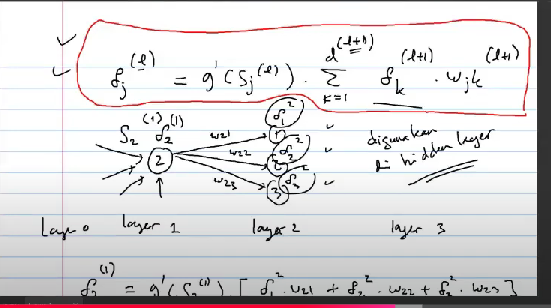

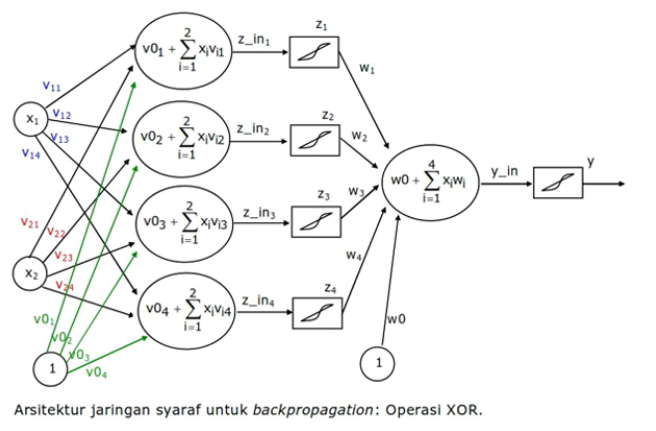